## Multi Task Model Updated

## Libraries

In [ ]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs') #remove all files in this directory
except:
  pass

np.random.seed(42)

## Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

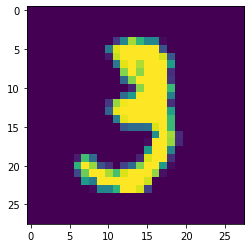

In [ ]:
plt.imshow(x_train[10])
y_train[10]
y_train[0:100] #show sample of the labels

In [ ]:
def create_example(x, y):
  """
   x : input image
   y: label
   return new image
  """
  c = np.random.randint(0,2) #color return 0 or 1
  image = 0.5 * np.random.rand(28, 28, 3) # will have random values
  image[:, :, c] += 0.5 * x / 255.0 # we will put our main image data or featues to this channel #some manner of normalization as they are randomly
  return image, y, c

digit: 5, color: red


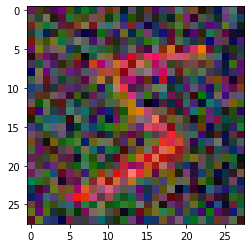

In [ ]:
colors = {0: 'red', 1: 'green'}

x, y, c = create_example(x_train[0], y_train[0])
print(f'digit: {y}, color: {colors[c]}')

plt.imshow(x)
plt.show()

## Generate the new data (colored)

In [ ]:
def generate_data(x, y):

  num_images = len(y)
  x_data = np.zeros((num_images, 28, 28, 3))
  y_data = np.zeros((num_images,))
  c_data = np.zeros((num_images,))#color batch
  
  for i in range(0, num_images):
    image, digit, color = create_example(x[i], y[i]) #returns the new image
    x_data[i] = image
    y_data[i] = digit
    c_data[i] = color

  return x_data, y_data, c_data

In [ ]:
x_data_train, y_data_train, c_data_train = generate_data(x_train, y_train)

59989
digit: 8.0, color: 1.0


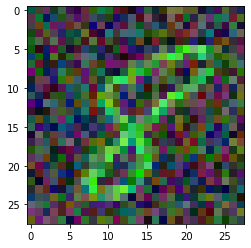

In [ ]:
random_idx = np.random.randint(0, len(x_data_train))
print(random_idx)
print(f'digit: {y_data_train[random_idx]}, color: {c_data_train[random_idx]}')

plt.imshow(x_data_train[random_idx])
plt.show()

## Create Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(28, 28, 3), name='input')

# first convolution layer
conv_1 = Conv2D(32, 3, name='conv_1')(input_) #filters #kernel_size
act_1 = Activation('relu', name='act_1')(conv_1)

#output the color => sigmoid 0, 1
# Max Pooling layer
pool_1 = MaxPool2D(4, name='pool_1')(act_1)
flat_1 = Flatten(name='flat_1')(pool_1)

# First output => Color binary Classification
color = Dense(1, activation='sigmoid', name='color')(flat_1) #one neuron

conv_2 = Conv2D(32, 3, name='conv_2')(act_1) #filters #kernel_size
act_2 = Activation('relu', name='act_2')(conv_2)

#complete convolution layers to output the multi classification
conv_3 = Conv2D(32, 3, name='conv_3', padding='same')(act_2)
act_3 = Activation('relu', name='act_3')(conv_3)

conv_4 = Conv2D(32, 3, name='conv_4', padding='same')(act_3)
act_4 = Activation('relu', name='act_4')(conv_4)

conv_5 = Conv2D(32, 3, name='conv_5', padding='same')(act_4)
act_5 = Activation('relu', name='act_5')(conv_5)

pool_2 = MaxPool2D(4, name='pool_2')(act_5)
flat_2 = Flatten(name='flat_2')(pool_2)

#output digit 0 to 9 classes => Multi classes
digit = Dense(10, activation='softmax', name='digit')(flat_2)

#defining our model => Multi task
model = tf.keras.models.Model(input_, [digit, color])

model.compile(
    # multiple loss functions for optimization
    loss={
        'digit': 'sparse_categorical_crossentropy',
        'color': 'binary_crossentropy'
    },
    optimizer='rmsprop', # Gradient Descent in optimization #algorithm for optimization
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 26, 26, 32)   896         ['input[0][0]']                  
                                                                                                  
 act_1 (Activation)             (None, 26, 26, 32)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 24, 32)   9248        ['act_1[0][0]']                  
                                                                                              

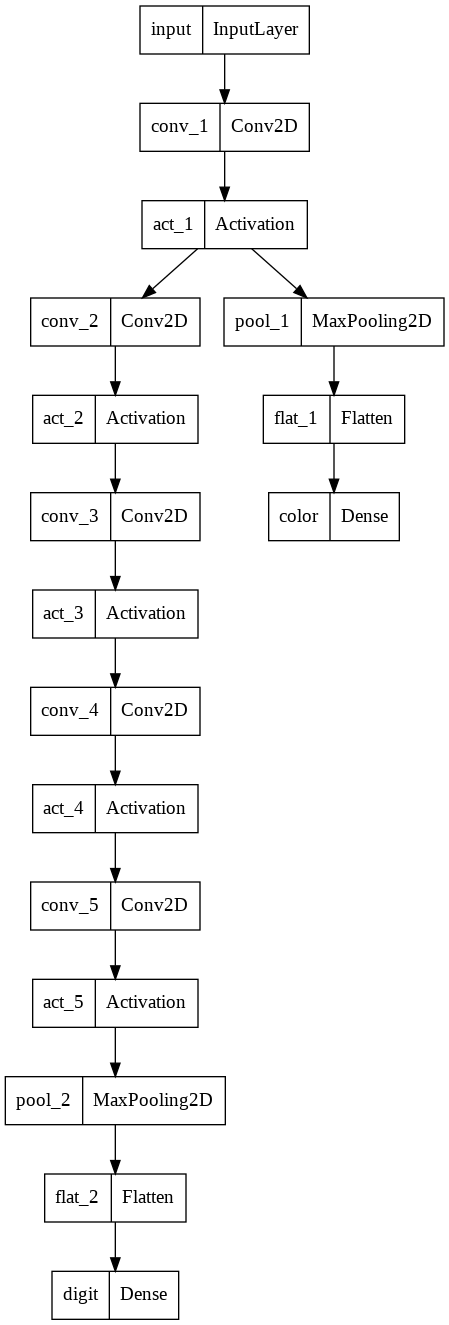

In [ ]:
tf.keras.utils.plot_model(model)

## Model Training

In [ ]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [ ]:
_ = model.fit(
    x = x_data_train,
    y = [y_data_train, c_data_train],
    validation_split = 0.2,
    # hyper parameters
    steps_per_epoch = 200,
    validation_steps = 100,
    epochs=10,
    callbacks=[
               Logger(),
               tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ],
    verbose=False
)

============================== 1 ==============================
digit_accuracy: 1.00, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 1.00, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 1.00, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 1.00, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 1.00, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 1.00, color_accuracy: 1.00
val_digit_accuracy: 0.98, val_color_accuracy: 1.00
============================== 7 ===================

In [ ]:
x_data_test, y_data_test, c_data_test = generate_data(x_test, y_test)

In [ ]:
model.evaluate(x_data_test, [y_data_test, c_data_test])

313/313 [==============================] - 2s 8ms/step - loss: 0.1523 - digit_loss: 0.1523 - color_loss: 2.0665e-07 - digit_accuracy: 0.9838 - color_accuracy: 1.0000


[0.15231233835220337,
 0.15231211483478546,
 2.066497160058134e-07,
 0.9837999939918518,
 1.0]

## Model Accuracy for Test Data 98.43 % for digit and 100% for color 

## Visualize Predictions

In [ ]:
preds = model.predict(x_data_test)

In [ ]:
def visualize_random_sample():
  random_idx = np.random.randint(0, len(x_data_test))

  pred_digit = np.argmax(preds[0][random_idx])
  pred_color = int(preds[1][random_idx] > 0.5)

  label_digit = y_data_test[random_idx]
  label_color = c_data_test[random_idx]

  print(f'Label: {label_digit}, {colors[label_color]}')
  print(f'Prediction: {pred_digit}, {colors[pred_color]}')
  plt.imshow(x_data_test[random_idx])

Label: 7.0, green
Prediction: 7, green


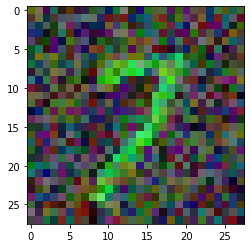

In [ ]:
visualize_random_sample()

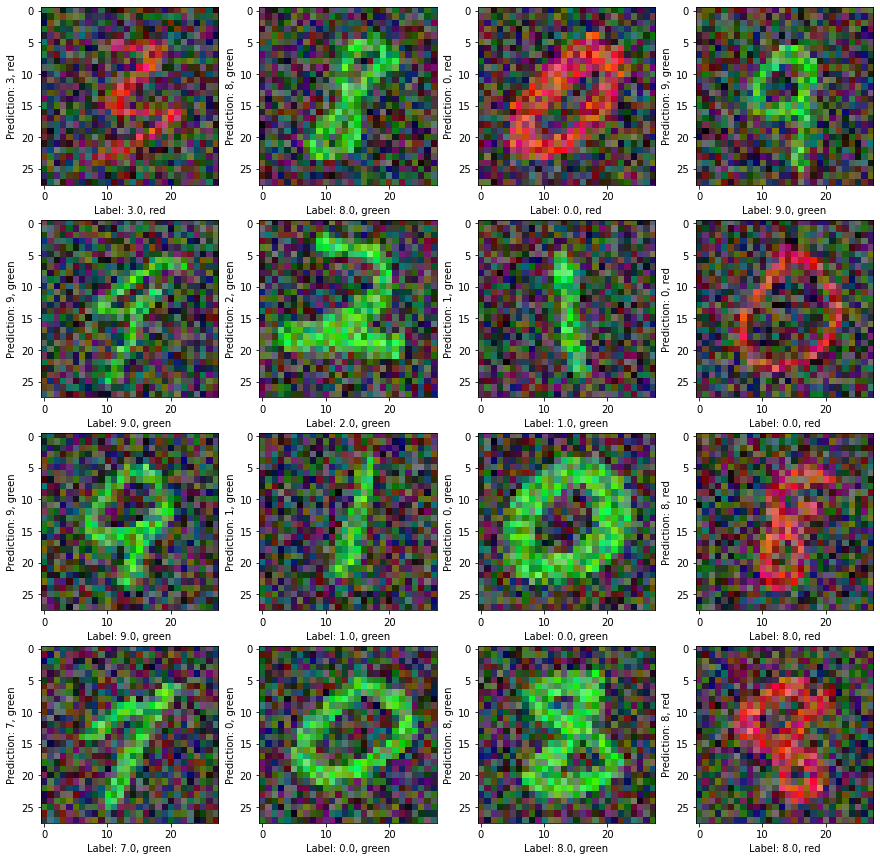

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(0, 16):
  plt.subplot(4,4, i+1)
  random_idx = np.random.randint(0, len(x_data_test))

  pred_digit = np.argmax(preds[0][random_idx])
  pred_color = int(preds[1][random_idx] > 0.5)

  label_digit = y_data_test[random_idx]
  label_color = c_data_test[random_idx]

  plt.xlabel(f'Label: {label_digit}, {colors[label_color]}')
  plt.ylabel(f'Prediction: {pred_digit}, {colors[pred_color]}')
  plt.imshow(x_data_test[random_idx])